In [136]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import re

%matplotlib inline

In [144]:
df = pd.read_csv('20160506 CF YL BSM Metabolite peak table.csv', na_values =0)
df.drop(0,inplace=True)
df = df.transpose()
df.reset_index(inplace=True)
old_cols = df.keys()
new_cols = [re.sub("[\(\[].*?[\)\]]", "", x) for x in df.iloc[0,:].tolist()]

df.columns = new_cols
df.drop(0,inplace=True)
df.rename(columns={new_cols[0]: 'file'}, inplace=True)
df.fillna(0,inplace=True)

# time_point = []
for i,row in df.iterrows():
    time = [s for s in row['file'].split('.')[0].split() if s.isdigit()][-1].zfill(3)
    df.loc[i,'time'] = time + 'hrs'
    temp = ''
    if 'CF' in row['file']:
        temp = temp + " Yarrowia"
    if 'YL' in row['file']:
        temp = temp + " Cellulomonas"
    temp = temp.strip().replace(' ',' + ')
    df.loc[i,'culture'] = temp
    df.loc[i,'group'] = temp+" "+time

df.sort('group',inplace=True)
df = df.convert_objects(convert_numeric=True)


# df.groupby('group').mean()[df.columns != 'file']
# df.groupby('group').head()
df_groups = df.groupby('group').mean()
df_groups.head()

,myristic acid,succinic acid,uracil,xanthine,5-aminovaleric acid 2,D-threitol,D-mannose 2,benzoic acid,citric acid,L-glutamic acid 1,...,13C6 glucose,13C6 vanillic acid,"2-pyrrolidone-5-carboxylic acid, TMS",Arabinose,Disaccharide,Disaccharide,Disaccharide,Galactose,Glucose,Xylose
group,,,,,,,,,,,,,,,,,,,,,
Cellulomonas 000,623050.666667,990065.666667,35148.333333,21189.666667,2077.000000,42456.666667,42111.000000,4053.000000,477504.000000,659441.333333,...,573328.333333,256311.333333,1548865.000000,3702.000000,1010070.000000,93159.666667,2325526.000000,7880.000000,43531.333333,18838.000000
Cellulomonas 024,590096.000000,70563.666667,31430.000000,37299.333333,2407.666667,24805.000000,1903.666667,36066.333333,127136.000000,4650.666667,...,540394.666667,253765.333333,355138.666667,3415.333333,877804.666667,75977.666667,1947589.666667,32.000000,5982.666667,12458.666667
Cellulomonas 037,543012.500000,148142.000000,25659.000000,68186.500000,1569.000000,9950.000000,3413.500000,36426.500000,30933.000000,161835.000000,...,300161.500000,150777.500000,413353.000000,2445.000000,513848.000000,53224.500000,1316985.000000,121.000000,810.500000,12273.500000
Cellulomonas 048,626235.000000,129617.500000,22857.500000,43520.000000,1793.500000,13159.500000,1548.000000,42663.500000,47247.000000,5445.500000,...,539054.000000,244374.000000,533729.500000,2849.000000,890143.500000,67704.000000,1991393.500000,44.000000,6145.000000,19528.500000
Cellulomonas 118,576047.666667,1596603.666667,42752.666667,130406.666667,4148.000000,10550.333333,2728.333333,37654.666667,33711.666667,7201.333333,...,522384.000000,228685.333333,206951.333333,2752.666667,994471.333333,103860.333333,2311602.666667,64.333333,4971.666667,23201.666667


In [145]:
M = (df_groups.as_matrix()+1)**0.5
row_min = M.min(axis=0)
M = M  - row_min[np.newaxis,:]
row_max = M.max(axis=0)
M = M / row_max[np.newaxis, :]

In [146]:
import string
printable = set(string.printable)
compound_names = []
for s in df_groups.keys():
    compound_names.append(filter(lambda x: x in printable, s))

In [147]:
def get_axis_limits(ax, scale=.93):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

plt.rcParams['pdf.fonttype']=42
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['lines.linewidth'] = 3
# plt.rcParams('text', usetex=True)


In [154]:
def plot_dendrogram_with_square_distance_matrix(matrix1,distance1,matrix_legend,label1,colormap,label2,sample_labels):#,matrix2,matrix_legend,color_helper,distance1,distance2,label1,label2,second_plot_type,colormap,second_plot_labels,filename):
    fig = plt.figure(figsize=(38,20))
    gs = gridspec.GridSpec(1, 2,width_ratios=[1,2])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ddata = dendrogram(linkage(pdist(matrix1,distance1), method='average'),
                       labels=matrix_legend,
                       orientation='left',
                       ax=ax1,
                       color_threshold =1)

    ax1.set_xlabel(label1,fontsize=14,fontweight='bold')
    ax1.yaxis.grid(zorder=0)

    ax1.annotate('A', xy=get_axis_limits(ax1),fontsize=40)

    a = ax2.imshow(matrix1[ddata['leaves'],:],interpolation='nearest',cmap=colormap,origin='lower')#, extent=[0, 1, 0, 1])
    ax2.set_aspect('auto')
    ax2.set_yticks(range(len(ddata['leaves'])))
    ax2.set_yticklabels([])
    ax2.set_xticks(range(len(sample_labels)))
    ax2.set_xticklabels(sample_labels,rotation=90)#,alignment='left')
    cb = plt.colorbar(a)
    cb.ax.yaxis.set_ticks_position('left')
    cb.set_label(label2,fontsize=18,fontweight='bold')


    ax2.yaxis.grid(zorder=0)
    ax2.annotate('B', xy=get_axis_limits(ax2),fontsize=40)
    ax2.yaxis.grid(zorder=0)

    plt.tight_layout()
    plt.show()
    fig.savefig('y_cf_gc_avg.pdf')

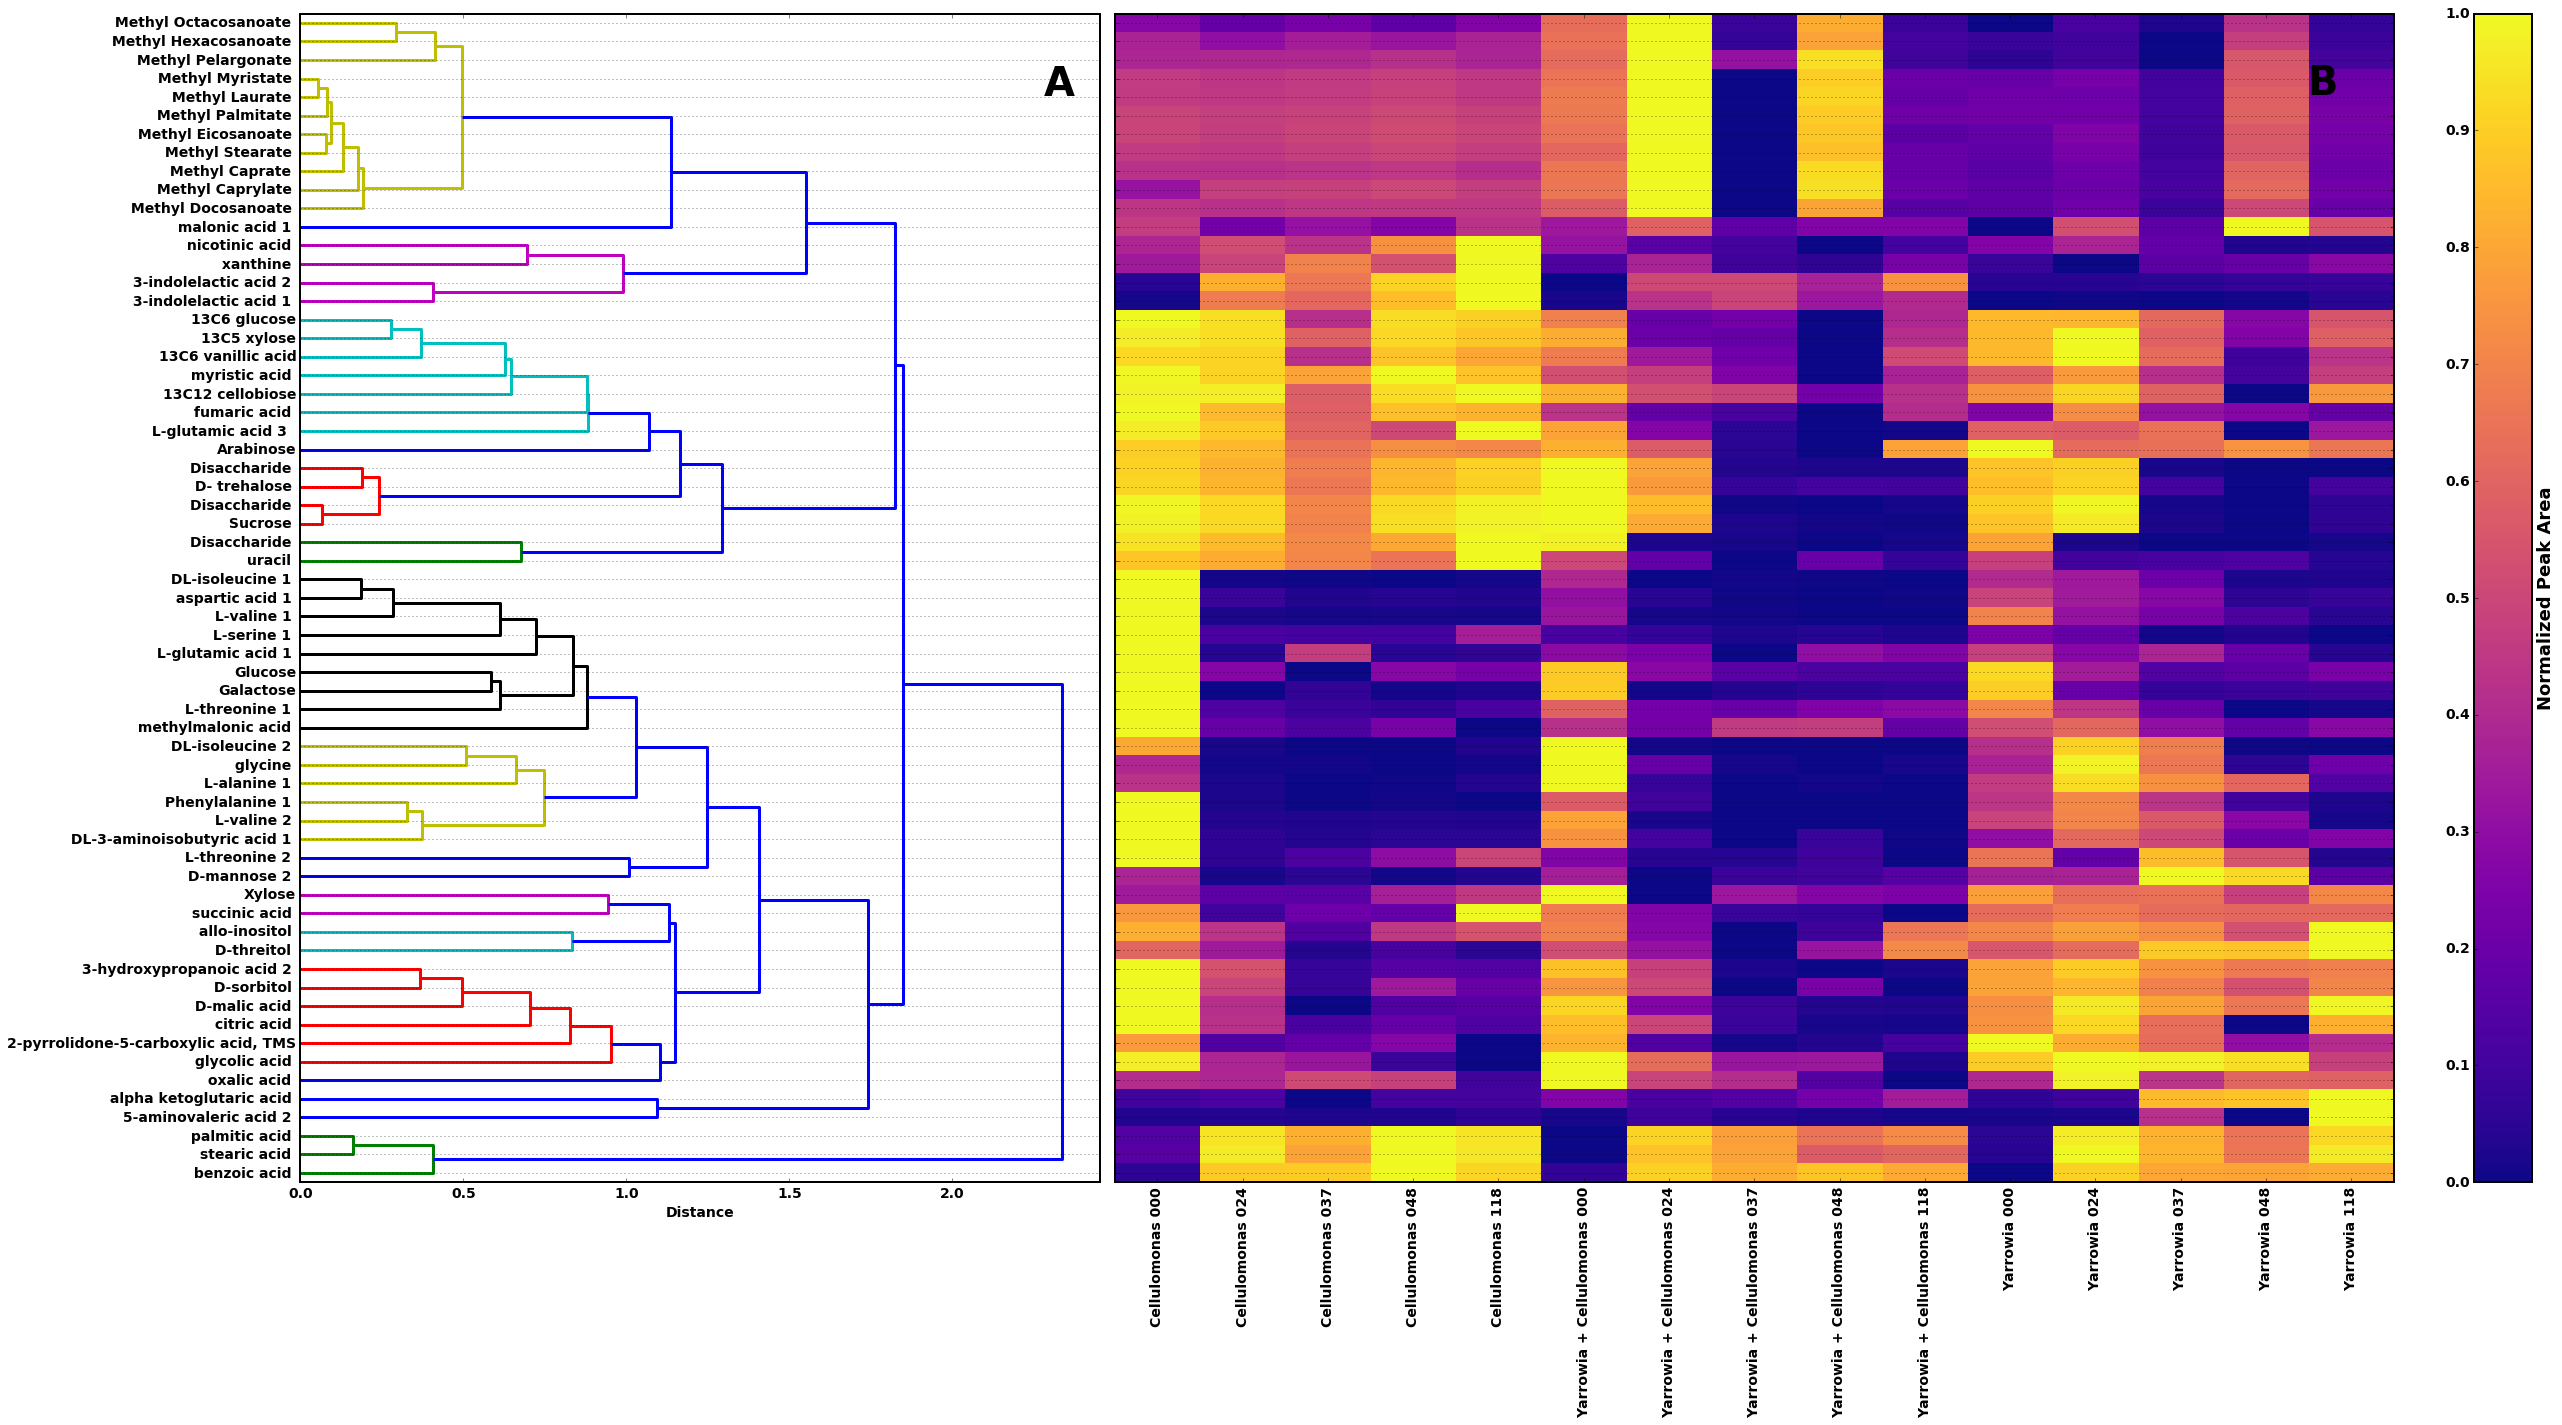

In [155]:
plot_dendrogram_with_square_distance_matrix(np.transpose(M),'euclidean',compound_names,'Distance','plasma','Normalized Peak Area',df_groups.index.values)